# Implementation of Fang & Oosterle (2008) : A novel pricing method for european options based on Fourier-Cosine series expansions (Part I/II) 

__Quick Tutorial for Jupyter Notebook Usage:__

- To run the whole notebook, simply click __Cell__ in the toolbar above and select __Run All__. You should see some nice plots at the very end.
- You can also run each cell on its own, by selecting it and pressing __Shift+Enter__ 

In [1]:
%matplotlib inline

import cmath   # c stands for complex (to handle complex numbers)
import numpy as np
import matplotlib.pyplot as plt

/Users/Simon/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Simon/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Approximating different densities

<img src="figures/f_9.png" width="480">
<img src="figures/f_11.png" width="460">

In [2]:
def Fk_function(a,b,k, char_fun):
    """
    Function (9) in the F&O paper
    Args:
        a : float, left border of the trucated integral, e.g.(mean-6*std)
        b : float, right border of the truncated integral, e.g. (mean-6*std)
        k : coeﬃcients of the summand (runs from 0 to N-1)
        char_fun : a characteristic function
        
    Returns:
        Fk, which is used in further functions
    """
    
    # u is inside our characteristic function \phi
    u = k * cmath.pi / (b-a)
    
    # inside the curly braces is our complex number
    complex_number = char_fun(u) * cmath.exp(-1j*k*a*cmath.pi / (b-a))
    
    # .real gets us the real part (written Re in the formula above)
    return 2 / (b-a) * complex_number.real

In [3]:
def get_Fk_values(a, b, char_fun, N):
    """
    We only want to do this once and not for each x
    Args:
        a : float, left border of the trucated integral, e.g. mean-6*std
        b : float, right border of the truncated integral, e.g. mean+6*std
        char_fun : a characteristic function, taking 1 argument (u)
        N: int, should be between 50 and 500
        
    Returns:
       np.array of shape (N,) containing the values computed by Fk for each k 
    """
    # This is a numpy placeholder for our values obtained by Fk
    values_Fk = np.zeros(N)
    
    # here we fill our placeholder with the correct values of Fk for each k
    for k in range(N):
        values_Fk[k] = Fk_function(a,b,k,char_fun)
        
    return values_Fk

In [4]:
def f_x(x, values_Fk, a, b, N):
    """
    Params:
        x : float, value at which to evaluate f_x
        values_Fk : np.array of shape (N,) containing the values computed by Fk
        a : float, left border of the trucated integral, e.g. mean-6*std
        b : float, right border of the truncated integral, e.g. mean+6*std
        N: int, should be between 50 and 500
    Returns:
        Approximation of the Inverse Fourier Integral via Cosine Expansion
    """
    result = 0
    
    for k in range(N):
        
        # we can look up the current value for Fk from above
        # (nice thing: no computation needed here)
        current_Fk = values_Fk[k]
        
        summand = current_Fk * cmath.cos(k*cmath.pi*(x-a)/(b-a))
        
        # first summand is only half weighted (see the ' in the sum formula)
        if k == 0:
            result += 0.5 * summand
        
        else:
            result += summand
            
    return result

In [5]:
def get_values(a,b,characteristic_function,N, interval):
    """
    Returns: tuple of two 1-dimensional np.arrays, with corresponding x and y 
             values, where x are evenly spaced values in the given interval
             and y = f_x(x) 
    """
    # First get the values for Fk
    values_Fk = get_Fk_values(a, b, characteristic_function, N)
    
    x_values = np.arange(*interval,0.1)
    y_values = np.zeros_like(x_values)
    
    for j, x in enumerate(x_values):
        
        y = f_x(x, values_Fk, a, b, N)
        y_values[j] = y
    
    return (x_values, y_values)

## Plotting different densities
### Defining characteristic functions

<img src="figures/char_fun.png" width="380">

In [6]:
def chf_normal(u):
    """
    Credit to:
    http://jpktd.blogspot.ch/2012/12/characteristic-functions-and-scipystats.html
    """
    loc = 0    # the mean
    scale = 1  # the standard deviation
    
    return cmath.exp(1j * u * loc - 0.5 * u**2 * scale**2)

def chi_sqared(u):
    n = 2      # degrees of freedom
    return 1 / ((1-2*1j*u)**(n/2))

def uniform(u):
    lower_border = -2
    upper_border = 2
    if u!= 0:
        nom = cmath.exp(1j*u*upper_border)-cmath.exp(1j*u*lower_border)
        denom = 1j*u*(upper_border-lower_border)
        return nom/denom

    else:
        return 0

def single(u):
    a = 0 # we want a single point at a=0
    return cmath.exp(1j*u*a)
    
def triangular(u):
    if u!=0:
        inside_braces = cmath.sin(u/2) / (u/2)
        return inside_braces**2
    
    else:
        return 0
    
all_char_functions = [chf_normal, chi_sqared, uniform, single, triangular]

### Simulating for different char functions and different N's

In [10]:
%%timeit
a = -10
b = 10
interval = (-4,4)

all_values = []

for N in (50,500):
    for char_function in all_char_functions:
        all_values.append(get_values(a,b,char_function,N,interval))

/Users/Simon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: ComplexWarning: Casting complex values to real discards the imaginary part


818 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


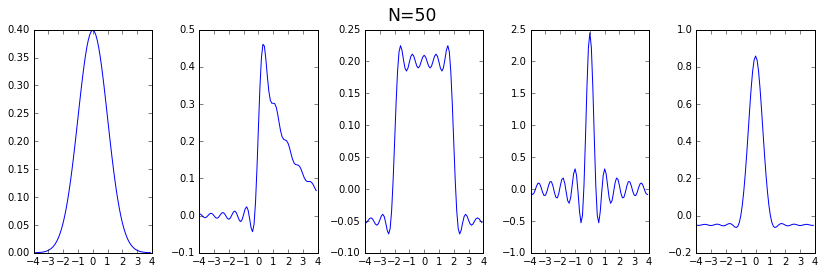

In [11]:
fig = plt.figure(figsize=(14,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle("N=50", fontsize="xx-large")
for values,j in zip(all_values[:5], range(1, 6)):
    plt.subplot(1, 5, j)
    plt.plot(*values);

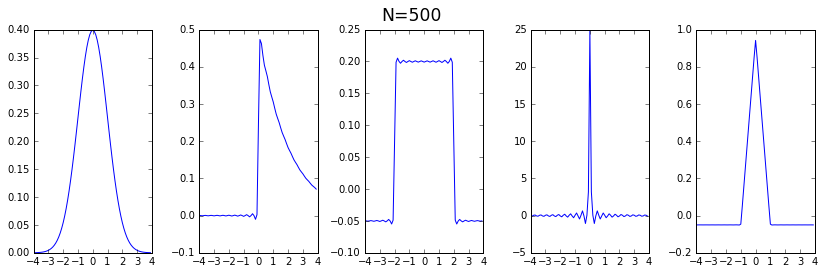

In [12]:
fig2 = plt.figure(figsize=(14,4))
fig2.subplots_adjust(hspace=0.4, wspace=0.4)
fig2.suptitle("N=500", fontsize="xx-large")
for values,j in zip(all_values[5:], range(1, 6)):
    plt.subplot(1, 5, j)
    plt.title("")
    plt.plot(*values);